##1. Importing necessary libraries


In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##2. Loading the data


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/facial emotional/facial expression/fer2013.csv')
data.shape

(35887, 3)

In [ ]:
data.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

In [ ]:
data.head(10)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


##3. Data pre-processing




In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

####3.1 Shuffling the data


In [ ]:
data = data.sample(frac=1)


####3.2 One Hot *Encoding*

In [ ]:
labels = to_categorical(data[['emotion']], num_classes=7)


In [ ]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

####3.3 Standardization

In [ ]:
pixels = train_pixels.reshape((35887*2304,1))


In [ ]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

####3.4 Reshaping the data (48,48)

In [ ]:
pixels = train_pixels.reshape((35887, 48, 48,1))


####3.5 Train test validation split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


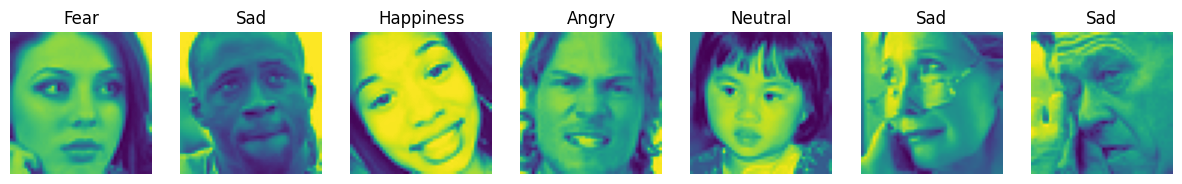

In [ ]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

###3.6 Data augmentation using ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [ ]:
datagen.fit(X_train)
valgen.fit(X_val)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

##4. Design a model


####4.1 CNN model

In [ ]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

In [ ]:
model = cnn_model()


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

###4.2 Early stopping

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/20
454/455 [============================>.] - ETA: 0s - loss: 6.6678 - accuracy: 0.2095
Epoch 1: val_accuracy improved from -inf to 0.26285, saving model to best_model.h5
455/455 [==============================] - 41s 49ms/step - loss: 6.6588 - accuracy: 0.2093 - val_loss: 2.3781 - val_accuracy: 0.2628
Epoch 2/20
454/455 [============================>.] - ETA: 0s - loss: 2.2934 - accuracy: 0.2343
Epoch 2: val_accuracy improved from 0.26285 to 0.26471, saving model to best_model.h5
455/455 [==============================] - 23s 50ms/step - loss: 2.2932 - accuracy: 0.2342 - val_loss: 2.2627 - val_accuracy: 0.2647
Epoch 3/20
455/455 [==============================] - ETA: 0s - loss: 2.2914 - accuracy: 0.2628
Epoch 3: val_accuracy did not improve from 0.26471
455/455 [==============================] - 23s 49ms/step - loss: 2.2914 - accuracy: 0.2628 - val_loss: 2.5521 - val_accuracy: 0.2498
Epoch 4/20
455/455 [==============================] - ETA: 0s - loss: 2.5176 - accuracy: 0.34

###4.3 Visualizing results

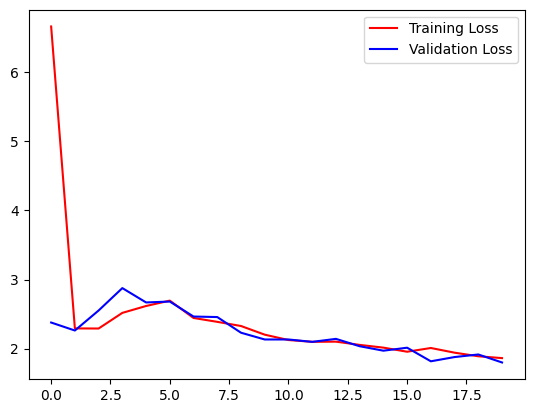

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

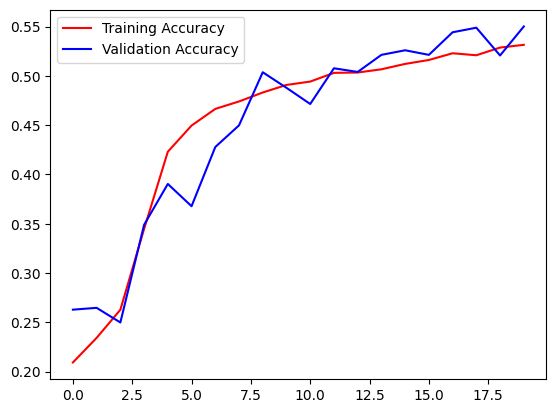

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 9ms/step - loss: 1.7838 - accuracy: 0.5573
Test Acc: 0.5572583079338074


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


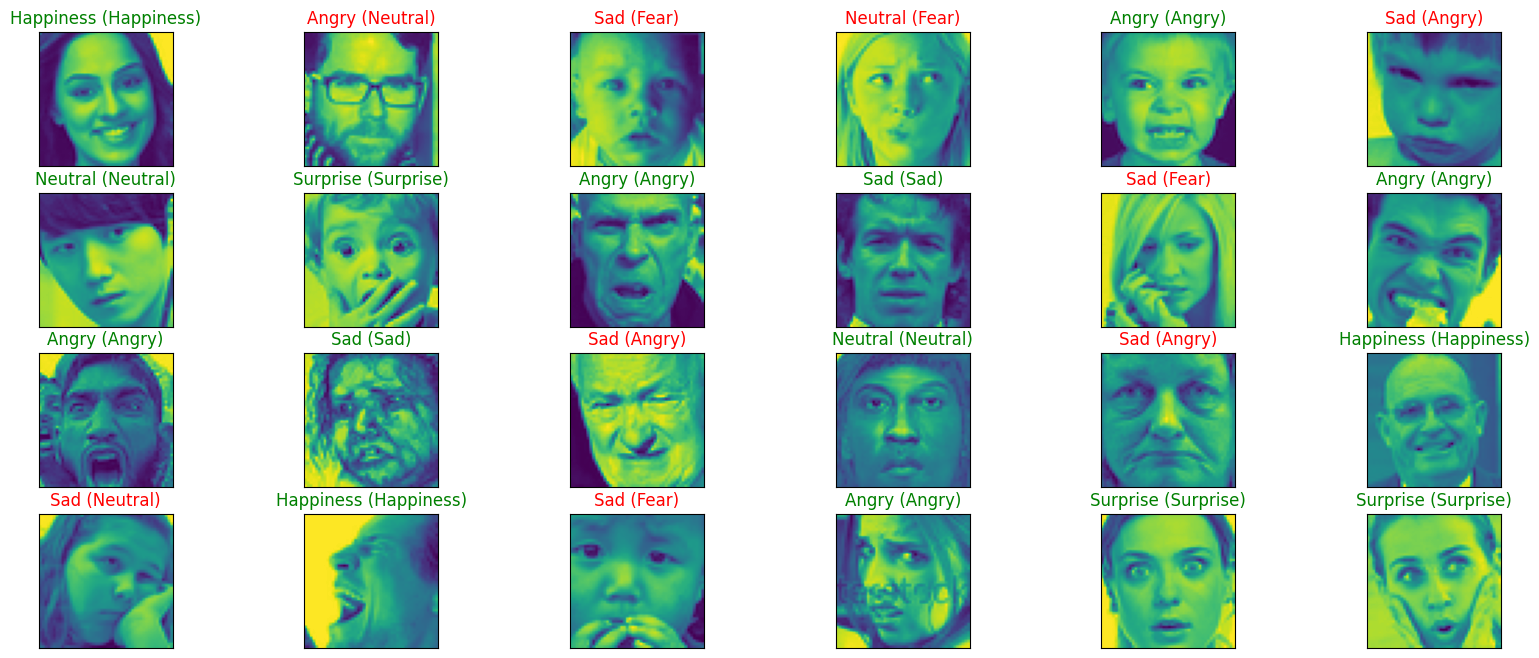

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

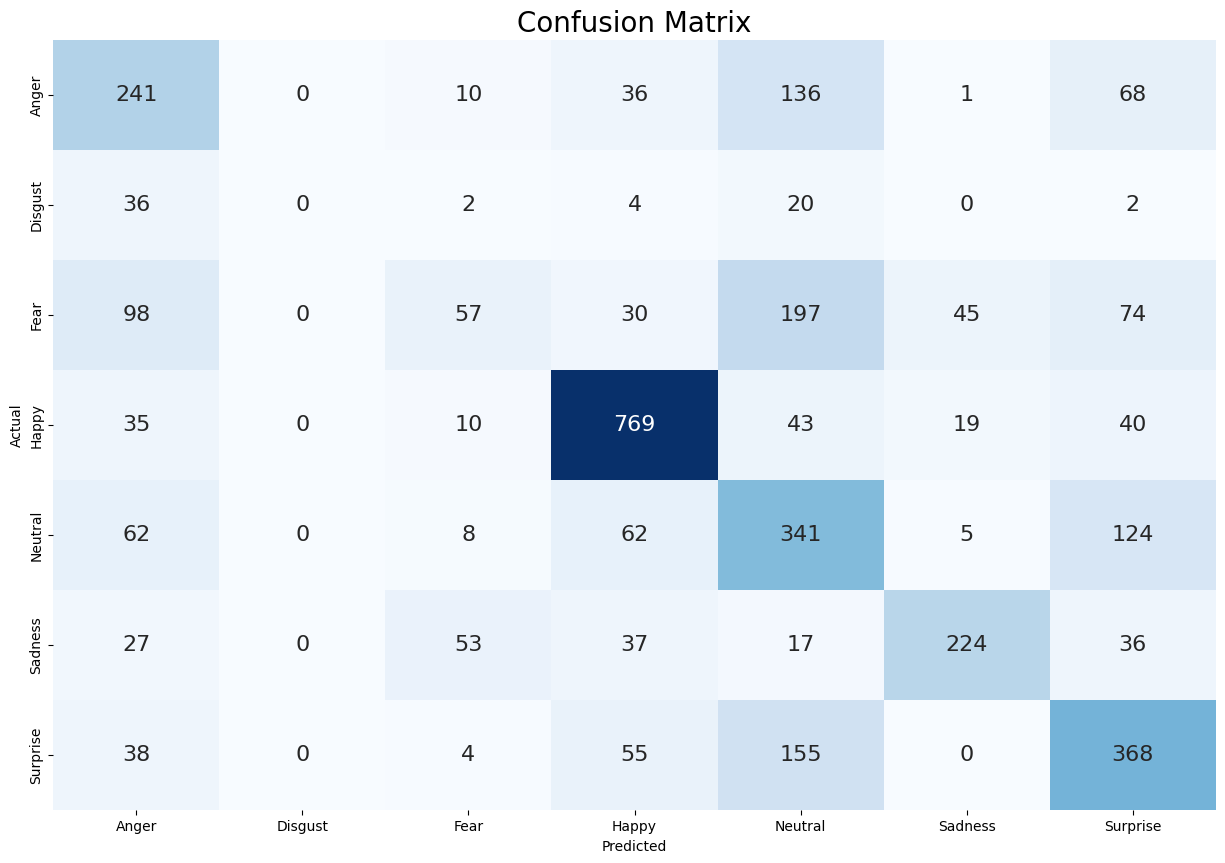

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.449     0.490     0.468       492
           1      0.000     0.000     0.000        64
           2      0.396     0.114     0.177       501
           3      0.774     0.840     0.806       916
           4      0.375     0.566     0.451       602
           5      0.762     0.569     0.651       394
           6      0.517     0.594     0.553       620

    accuracy                          0.557      3589
   macro avg      0.468     0.453     0.444      3589
weighted avg      0.550     0.557     0.537      3589



##5. Fine tuning


###5.1 Changing optimizer

In [ ]:
model = cnn_model()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.8318 - accuracy: 0.1624
Epoch 1: val_accuracy did not improve from 0.55015
455/455 [==============================] - 26s 51ms/step - loss: 14.8318 - accuracy: 0.1624 - val_loss: 14.0986 - val_accuracy: 0.2325
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.4073 - accuracy: 0.1800
Epoch 2: val_accuracy did not improve from 0.55015
455/455 [==============================] - 23s 50ms/step - loss: 14.4073 - accuracy: 0.1800 - val_loss: 13.8590 - val_accuracy: 0.2136
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 14.0638 - accuracy: 0.1853
Epoch 3: val_accuracy did not improve from 0.55015
455/455 [==============================] - 23s 50ms/step - loss: 14.0638 - accuracy: 0.1853 - val_loss: 13.5986 - val_accuracy: 0.2347
Epoch 4/30
455/455 [==============================] - ETA: 0s - loss: 13.7618 - accuracy: 0.1985
Epoch 4: val_accuracy did not improve from 0.55015
455

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 8.8097 - accuracy: 0.3399
Test Acc: 0.3399275541305542


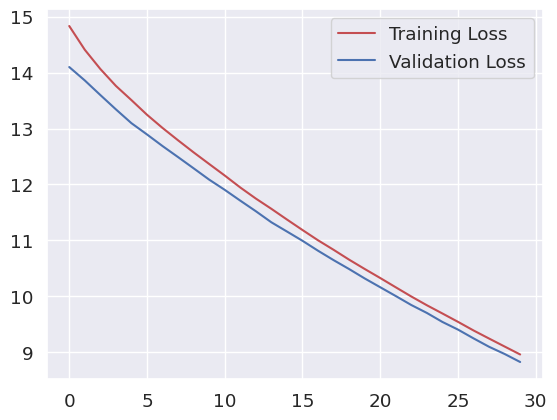

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

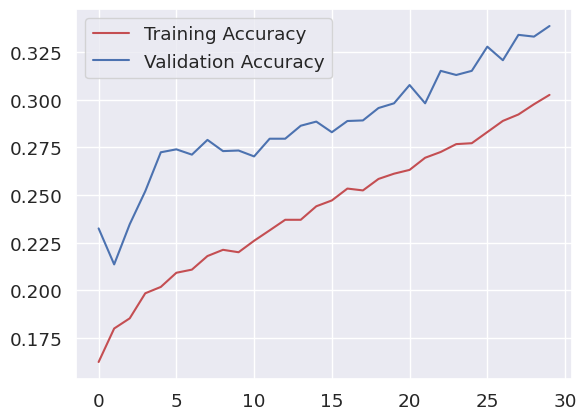

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

###5.2 Changing epoch number

In [ ]:
model = cnn_model()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
455/455 [==============================] - ETA: 0s - loss: 14.8437 - accuracy: 0.1565
Epoch 1: val_accuracy improved from -inf to 0.21950, saving model to best_model.h5
455/455 [==============================] - 26s 50ms/step - loss: 14.8437 - accuracy: 0.1565 - val_loss: 14.0763 - val_accuracy: 0.2195
Epoch 2/50
455/455 [==============================] - ETA: 0s - loss: 14.3786 - accuracy: 0.1729
Epoch 2: val_accuracy improved from 0.21950 to 0.23901, saving model to best_model.h5
455/455 [==============================] - 22s 49ms/step - loss: 14.3786 - accuracy: 0.1729 - val_loss: 13.8464 - val_accuracy: 0.2390
Epoch 3/50
454/455 [============================>.] - ETA: 0s - loss: 14.0584 - accuracy: 0.1864
Epoch 3: val_accuracy improved from 0.23901 to 0.26316, saving model to best_model.h5
455/455 [==============================] - 22s 48ms/step - loss: 14.0582 - accuracy: 0.1863 - val_loss: 13.5421 - val_accuracy: 0.2632
Epoch 4/50
454/455 [============================>

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 6.5211 - accuracy: 0.4177
Test Acc: 0.4176650941371918


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


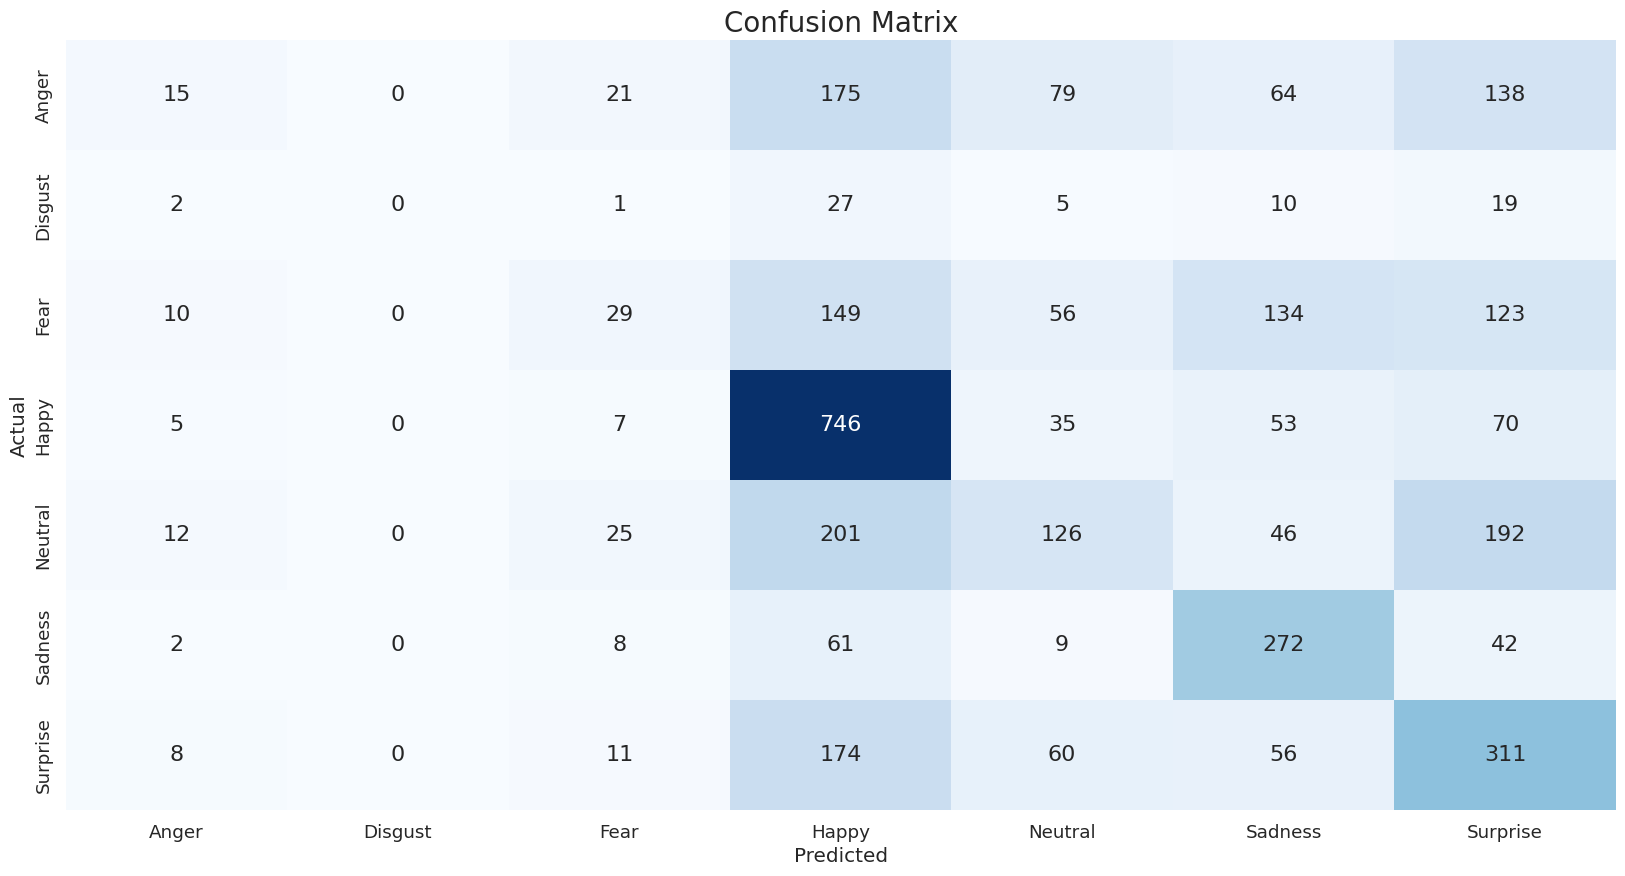

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))


              precision    recall  f1-score   support

           0      0.278     0.030     0.055       492
           1      0.000     0.000     0.000        64
           2      0.284     0.058     0.096       501
           3      0.487     0.814     0.609       916
           4      0.341     0.209     0.259       602
           5      0.428     0.690     0.529       394
           6      0.347     0.502     0.411       620

    accuracy                          0.418      3589
   macro avg      0.309     0.329     0.280      3589
weighted avg      0.366     0.418     0.349      3589

